# EDA

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [2]:
# Load aggregated eICU patient table
patient = pd.read_csv('raw_agg_patient_table.csv')
patient.shape

(17167, 192)

In [3]:
# Convert categorical variables to category 
categorical_cols = ['gender', 'age', 'ethnicity', 'apacheadmissiondx', 
                    'hospitaladmitsource', 'died','unittype', 'unitadmitsource',
                    'unitstaytype', 'intubated','aids', 'vent', 'dialysis',
                    'lymphoma', 'immunosuppression', 'diabetes', 
                    'numbedscategory', 'teachingstatus', 'hospitalregion']

for col in categorical_cols:
    patient[col] = patient[col].astype('category')

### Distribution of numeric variables

In [4]:
patient_num_vars = patient.select_dtypes(include=np.number)
num_vars_to_exclude = ['patientunitstayid', 'patienthealthsystemstayid', 
                       'wardid']
num_cols_to_keep = [col for col in patient_num_vars.columns if 
                    col not in(num_vars_to_exclude)]
patient_num_vars = patient_num_vars.loc[:, num_cols_to_keep]

In [5]:
pd.set_option('display.max_columns', None)
patient_num_vars.describe()

,hospitalid,admissionheight,admissionweight,dischargeweight,icuduration,weightdiffafterdischarge,urine,wbc,temperature,respiratoryrate,sodium,heartrate,meanbp,ph,creatinine,albumin,glucose,bilirubin,fio2,pao2,pco2,bun,meanapachescore,meanpredictedicumortality,meanpredictediculos,meanventdays,numberofinfusions,mininfusionrate,meaninfusionrate,maxinfusionrate,mindrugamount,meandrugamount,maxdrugamount,minvolumeoffluid,meanvolumeoffluid,maxvolumeoffluid,lab_mean_ALT (SGPT),lab_mean_AST (SGOT),lab_mean_BUN,lab_mean_Base Excess,lab_mean_FiO2,lab_mean_HCO3,lab_mean_Hct,lab_mean_Hgb,lab_mean_MCH,lab_mean_MCHC,lab_mean_MCV,lab_mean_MPV,lab_mean_O2 Sat (%),lab_mean_PT,lab_mean_PT - INR,lab_mean_PTT,lab_mean_RBC,lab_mean_RDW,lab_mean_WBC x 1000,lab_mean_albumin,lab_mean_alkaline phos.,lab_mean_anion gap,lab_mean_basos,lab_mean_bedside glucose,lab_mean_bicarbonate,lab_mean_calcium,lab_mean_chloride,lab_mean_creatinine,lab_mean_eos,lab_mean_glucose,lab_mean_lactate,lab_mean_lymphs,lab_mean_magnesium,lab_mean_monos,lab_mean_pH,lab_mean_paCO2,lab_mean_paO2,lab_mean_phosphate,lab_mean_platelets x 1000,lab_mean_polys,lab_mean_potassium,lab_mean_sodium,lab_mean_total bilirubin,lab_mean_total protein,lab_mean_troponin - I,lab_mean_urinary specific gravity,patient,minFi02,meanFi02,maxFi02,minbedsideglucose,meanbedsideglucose,maxbedsideglucose,mincvp,meancvp,maxcvp,minheartrate,meanheartrate,maxheartrate,minnoninvasivediastolic,meannoninvasivediastolic,maxnoninvasivediastolic,minnoninvasivemean,meannoninvasivemean,maxnoninvasivemean,minnoninvasivesystolic,meannoninvasivesystolic,maxnoninvasivesystolic,minrespiration,meanrespiration,maxrespiration,minsao2,meansao2,maxsao2,minst1,meanst1,maxst1,minst2,meanst2,maxst2,minst3,meanst3,maxst3,minsystemicdiastolic,meansystemicdiastolic,maxsystemicdiastolic,minsystemicmean,meansystemicmean,maxsystemicmean,minsystemicsystolic,meansystemicsystolic,maxsystemicsystolic,mintemperature,meantemperature,maxtemperature,resp_mean_Exhaled MV,resp_mean_FiO2,resp_mean_LPM O2,resp_mean_Mean Airway Pressure,resp_mean_PEEP,resp_mean_Peak Insp. Pressure,resp_mean_Plateau Pressure,resp_mean_RR (patient),resp_mean_SaO2,resp_mean_TV/kg IBW,resp_mean_Tidal Volume (set),resp_mean_Total RR,resp_mean_Vent Rate,aperiodic_minpaop,aperiodic_meanpaop,aperiodic_maxpaop,aperiodic_mincardiacoutput,aperiodic_meancardiacoutput,aperiodic_maxcardiacoutput,aperiodic_mincardiacinput,aperiodic_meancardiacinput,aperiodic_maxcardiacinput,aperiodic_minsvr,aperiodic_meansvr,aperiodic_maxsvr,aperiodic_minsvri,aperiodic_meansvri,aperiodic_maxsvri,aperiodic_minpvr,aperiodic_meanpvr,aperiodic_maxpvr,aperiodic_minpvri,aperiodic_meanpvri,aperiodic_maxpvri
count,17167.000000,16914.000000,16777.000000,9991.000000,17167.000000,9708.000000,16656.000000,16656.000000,16656.000000,16656.000000,16656.000000,16656.000000,16656.000000,16656.000000,16656.000000,16656.000000,16656.000000,16656.000000,16656.000000,16656.000000,16656.000000,16656.000000,14611.000000,14611.000000,14611.000000,7587.000000,5699.000000,2661.000000,2661.000000,2661.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,6672.000000,6736.000000,10240.000000,6183.000000,6705.000000,7064.000000,10237.000000,10175.000000,9290.000000,9872.000000,9873.000000,7297.000000,6112.000000,5358.000000,5542.000000,3934.000000,10098.000000,9386.000000,10213.000000,6957.000000,6676.000000,7998.000000,6922.000000,6535.000000,9781.000000,9858.000000,10174.000000,10234.000000,7217.000000,10205.000000,4688.000000,7699.000000,6464.000000,7623.000000,7227.000000,7302.000000,7358.000000,4421.000000,10080.000000,6925.000000,10195.000000,10249.000000,6529.000000,6692.000000,3203.000000,3696.000000,1.045500e+04,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000

There are several variables related to the APACHE score that have a minimum value of -1. We assume that these values are missing so we will recode these as null.

In [6]:
cols_to_recode = ['urine', 'wbc', 'temperature', 'respiratoryrate', 'sodium',
                  'heartrate', 'meanbp', 'ph', 'creatinine', 'albumin', 
                  'glucose', 'bilirubin', 'fio2', 'pao2', 'pco2', 'bun', 
                  'meanapachescore', 'meanpredictedicumortality', 
                  'meanpredictediculos']

for col in cols_to_recode: 
    patient.loc[patient[col] == -1, col] = np.nan

### Distribution of categorical features

In [7]:
# Define function to get categorical percentages for categorical variables
def get_categorical_percentages(df):
    """
    This function computes the percentages of categories for each categorical
    variable in the data.
    
    :param df: data
    :type df: pandas dataframe
    
    :return: prints each variable with their categories and respective 
    proportions
    """
    cat_df = df.select_dtypes(include='category')
    for var in cat_df.columns:
        perc = df[var].value_counts(normalize=True)
        print(var)
        print(perc)

In [8]:
# Recode age, teaching status and gender variables
patient.age = patient.age.cat.rename_categories({'> 89': 90})
patient.age = pd.to_numeric(patient.age, errors='coerce')

patient['age0-9'] = np.nan
patient.loc[(patient.age >= 0) & (patient.age <= 9), 'age0-9'] = 1
patient.loc[(patient.age > 9), 'age0-9'] = 0
patient['age0-9'] = patient['age0-9'].astype('category')

patient['age10-19'] = np.nan
patient.loc[(patient.age >= 10) & (patient.age <= 19), 'age10-19'] = 1
patient.loc[(patient.age > 19), 'age10-19'] = 0
patient['age10-19'] = patient['age10-19'].astype('category')

patient['age20-29'] = np.nan
patient.loc[(patient.age >= 20) & (patient.age <= 29), 'age20-29'] = 1
patient.loc[(patient.age > 29), 'age20-29'] = 0
patient['age20-29'] = patient['age20-29'].astype('category')

patient['age30-39'] = np.nan
patient.loc[(patient.age >= 30) & (patient.age <= 39), 'age30-39'] = 1
patient.loc[(patient.age > 39), 'age30-39'] = 0
patient['age30-39'] = patient['age30-39'].astype('category')

patient['age40-49'] = np.nan
patient.loc[(patient.age >= 40) & (patient.age <= 49), 'age40-49'] = 1
patient.loc[(patient.age > 49), 'age40-49'] = 0
patient['age40-49'] = patient['age40-49'].astype('category')

patient['age50-59'] = np.nan
patient.loc[(patient.age >= 50) & (patient.age <= 59), 'age50-59'] = 1
patient.loc[(patient.age > 59), 'age50-59'] = 0
patient['age50-59'] = patient['age50-59'].astype('category')

patient['age60-69'] = np.nan
patient.loc[(patient.age >= 60) & (patient.age <= 69), 'age60-69'] = 1
patient.loc[(patient.age > 69), 'age60-69'] = 0
patient['age60-69'] = patient['age60-69'].astype('category')

patient['age70-79'] = np.nan
patient.loc[(patient.age >= 70) & (patient.age <= 79), 'age70-79'] = 1
patient.loc[(patient.age > 79), 'age70-79'] = 0
patient['age70-79'] = patient['age70-79'].astype('category')

patient['age80-89'] = np.nan
patient.loc[(patient.age >= 80) & (patient.age <= 89), 'age80-89'] = 1
patient.loc[(patient.age > 89), 'age80-89'] = 0
patient['age80-89'] = patient['age80-89'].astype('category')

patient['age>89'] = np.nan
patient.loc[(patient.age > 89), 'age>89'] = 1
patient.loc[(patient.age <= 89), 'age>89'] = 0
patient['age>89'] = patient['age>89'].astype('category')
patient.drop(columns='age', inplace=True)

patient.teachingstatus = np.where(patient.teachingstatus == 't', 1, 0)
patient.teachingstatus = patient.teachingstatus.astype('category')

patient['gendermale'] = np.nan
patient.loc[patient.gender == 'Male', 'gendermale'] = 1
patient.loc[patient.gender == 'Female', 'gendermale'] = 0
patient.gendermale = patient.gendermale.astype('category')
patient.drop(columns='gender', inplace=True)

In [9]:
get_categorical_percentages(patient)

ethnicity
Caucasian           0.779845
African American    0.120385
Other/Unknown       0.041645
Hispanic            0.037096
Asian               0.015122
Native American     0.005907
Name: ethnicity, dtype: float64
apacheadmissiondx
Pneumonia, bacterial                                                                       0.165958
Emphysema/bronchitis                                                                       0.147492
Arrest, respiratory (without cardiac arrest)                                               0.097629
Embolus, pulmonary                                                                         0.081202
Respiratory - medical, other                                                               0.077824
Obstruction-airway (i.e., acute epiglottitis, post-extubation edema, foreign body, etc)    0.042582
Pneumonia, other                                                                           0.039553
Pneumonia, aspiration                                             

There are a few features with highly skewed distributions towards one category over the other (99% vs 1%) including `aids` and `lymphoma`. We will drop these features,`apacheadmissiondx` given that there are a lot of categories for this feature, and `unitstaytype` since it is similar to the `hospitaladmitsource` variable.

In [10]:
patient.drop(columns=['aids', 'lymphoma', 'unitstaytype'], inplace=True)

In [11]:
# One hot encode categorical variables
categorical_df = patient.select_dtypes(include='category')
cols_to_encode = [col for col in categorical_df.columns 
                  if categorical_df[col].nunique() > 2]
ind_vars = pd.get_dummies(categorical_df.loc[:, cols_to_encode])
ind_vars = ind_vars.apply(lambda x: x.astype('category'))

# Remove hospital region from list of columns to drop because it will be used 
# for stratified sampling later
cols_to_encode.remove('hospitalregion')

patient = patient.drop(columns=cols_to_encode)
patient = pd.concat([patient, ind_vars], axis=1)

### Visualize numeric variables by target

In [12]:
num_df = patient.select_dtypes(include=np.number)
num_df.shape

(17167, 168)

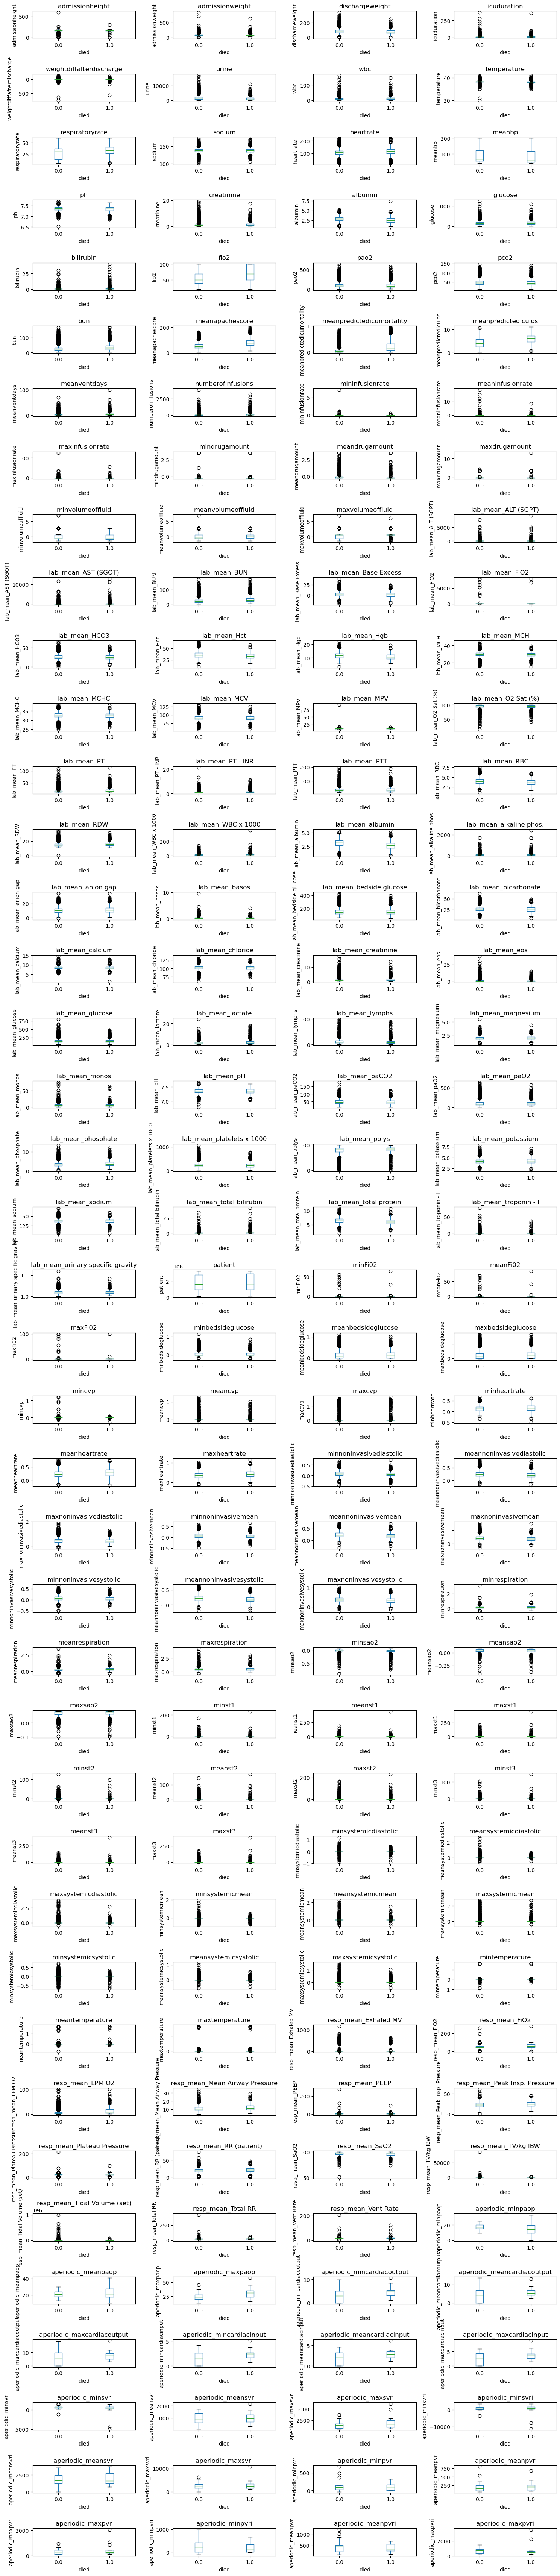

In [13]:
num_df = patient.select_dtypes(include=np.number)
num_vars_to_exclude = ['patientunitstayid', 'patienthealthsystemstayid', 
                       'wardid', 'hospitalid']
num_cols_to_keep = [col for col in num_df.columns if 
                    col not in(num_vars_to_exclude)]
num_df = num_df.loc[:, num_cols_to_keep]
num_df['died'] = patient['died']

fig=plt.figure(figsize=(15,70))
variables = num_df.columns.drop('died')
for i, var in enumerate(variables):
    ax=fig.add_subplot(42, 4, i+1)
    ax=plt.gca()
    num_df.boxplot(column=var,
                   by='died', 
                   grid=False, 
                   ax=ax)
    ax.set(ylabel=var)
    ax.set_title(var)
fig.suptitle('')
fig.tight_layout()
plt.show()

### Distribution of categorical variables by target

In [14]:
# Get proportions of target for each categorical variable
categorical_df = patient.select_dtypes(include='category')
variables = categorical_df.columns.drop('died')  
for var in variables:
    print(pd.crosstab(categorical_df[var], 
                      categorical_df['died'], 
                      normalize='columns'), "\n")

died            0.0       1.0
intubated                    
0.0        0.836916  0.671366
1.0        0.163084  0.328634 

died       0.0       1.0
vent                    
0.0   0.622036  0.418571
1.0   0.377964  0.581429 

died           0.0       1.0
dialysis                    
0.0       0.973929  0.976179
1.0       0.026071  0.023821 

died                    0.0       1.0
immunosuppression                    
0.0                0.962141  0.939232
1.0                0.037859  0.060768 

died           0.0       1.0
diabetes                    
0.0       0.807447  0.824016
1.0       0.192553  0.175984 

died                 0.0      1.0
teachingstatus                   
0               0.751829  0.73659
1               0.248171  0.26341 

died                 0.0       1.0
hospitalregion                    
Midwest         0.341855  0.261965
Northeast       0.093376  0.109824
South           0.369996  0.446851
West            0.194773  0.181360 

died         0.0  1.0
age0-9        

There seems to be a significant difference in the proportion of patients who died between the categories of all categorical variables except gender and patients age 70-79.

### Mortality by discharge time

In [15]:
patient.hospitaldischargetime24 = pd.to_datetime(patient.hospitaladmittime24, format='%H:%M:%S')
patient['hospitaldischargetimehr'] = patient.hospitaldischargetime24.dt.hour

In [16]:
temp = patient.copy()
temp['died'] = pd.to_numeric(temp['died'], errors='coerce')

discharge_hour_mortality = (
    temp.groupby('hospitaldischargetimehr')
        .agg(total=pd.NamedAgg(column='died', aggfunc='count'), 
             mortalitycount=pd.NamedAgg(column='died', aggfunc='sum'))
)
discharge_hour_mortality = (
    discharge_hour_mortality.assign(
        mortalityrate=(discharge_hour_mortality['mortalitycount'] / 
                       discharge_hour_mortality['total'])
    )
)
discharge_hour_mortality = discharge_hour_mortality.reset_index()

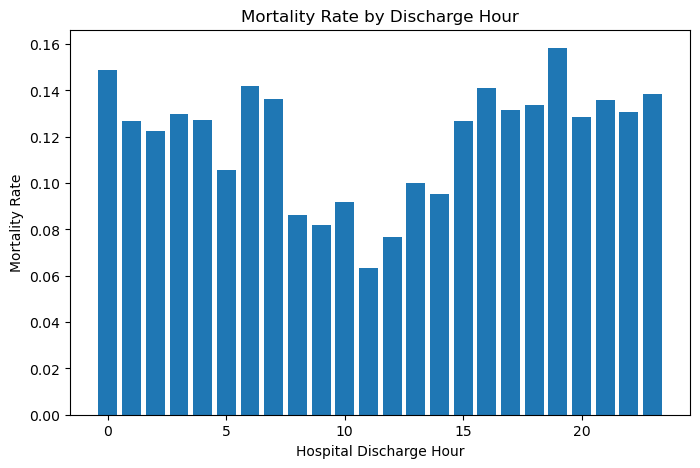

In [17]:
fig = plt.figure(figsize = (8, 5))
plt.bar(discharge_hour_mortality.hospitaldischargetimehr, 
        discharge_hour_mortality.mortalityrate)
plt.xlabel('Hospital Discharge Hour')
plt.ylabel('Mortality Rate')
plt.title('Mortality Rate by Discharge Hour')
plt.show()

In [18]:
# Create indicator variable that indicates the timespan covering the drop
# in mortality rate from hours 8 to 14.
patient['dischargehour8-14'] = (
    np.where((patient.hospitaldischargetimehr >= 8) & 
             (patient.hospitaldischargetimehr <= 14), 1, 0)
)

patient.drop(columns=['hospitaladmittime24', 'hospitaldischargetime24', 
                      'unitadmittime24', 'unitdischargetime24', 
                      'hospitaldischargetimehr'], inplace=True)

### Check for missing values

We will exclude any columns with more than 50% missing values and impute the other columns that do not exceed this threshold. However, we will first remove all patients who have a missing discharge status.

In [19]:
patient.died.isna().sum()

178

In [20]:
patient.dropna(subset='died', inplace=True)
patient.shape

(16989, 287)

In [21]:
missing_val_count = patient.isna().sum()
missing_df = pd.DataFrame(data={'variable': patient.columns, 
                                'missing_val_count': missing_val_count.values})
missing_df['missing_val%'] = (
    100 * (missing_df['missing_val_count'] / patient.shape[0])
)

# Get columns with more than 80% missing data
cols_to_drop = (
    missing_df.loc[missing_df['missing_val%'] >= 80, 'variable'].tolist()
)

patient.drop(columns=cols_to_drop, inplace=True)

We will impute the numeric variables with the median and categorical variable with the most frequent label. Before doing so, we will first split the data into training and testing to avoid data leakage.

### Train-Test Split

We will randomize our train and test sets by patient and use stratified sampling by `hospitalregion` and `teachingstatus` to ensure that the distribution of patients from different regions and whether the hospital they are in is a teaching hospital are equivalent between the training and test data sets.

In [22]:
# Drop missing values by variables that will be used for stratified sampling
patient.dropna(subset=['hospitalregion', 'teachingstatus'], inplace=True)
print(patient.shape)
print(patient.uniquepid.nunique())

# Remove irrelevant columns
patient.drop(columns=['patientunitstayid', 'patienthealthsystemstayid', 
                      'wardid', 'uniquepid'], 
             inplace=True)


X = patient.drop(columns=['died', 'hospitalid'])
y = patient.died
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    stratify=X[['hospitalregion',
                                                                'teachingstatus']],
                                                    random_state=607)

print(X_train.shape)
print(X_test.shape)

(15950, 245)
15950
(12760, 239)
(3190, 239)


##### Sanity check for stratified sampling

In [23]:
print(X_train.teachingstatus.value_counts(normalize=True))
print(X_test.teachingstatus.value_counts(normalize=True))

0    0.733699
1    0.266301
Name: teachingstatus, dtype: float64
0    0.733856
1    0.266144
Name: teachingstatus, dtype: float64


In [24]:
print(X_train.hospitalregion.value_counts(normalize=True))
print(X_test.hospitalregion.value_counts(normalize=True))

# Drop hospital region column 
X_train.drop(columns='hospitalregion', inplace=True)
X_test.drop(columns='hospitalregion', inplace=True)

South        0.379624
Midwest      0.331897
West         0.193025
Northeast    0.095455
Name: hospitalregion, dtype: float64
South        0.379310
Midwest      0.331975
West         0.193417
Northeast    0.095298
Name: hospitalregion, dtype: float64


### Impute missing values

In [25]:
# Impute numeric variables with median
numeric_vars = X_train.select_dtypes(include=np.number).columns
imputer = SimpleImputer(strategy='median')
imputer = imputer.fit(X_train[numeric_vars])
X_train[numeric_vars] = imputer.transform(X_train[numeric_vars])
X_test[numeric_vars] = imputer.transform(X_test[numeric_vars])

In [26]:
# Impute categorical variables with most frequent label
categorical_vars = X_train.select_dtypes(include='category').columns
imputer = SimpleImputer(strategy='most_frequent')
imputer = imputer.fit(X_train[categorical_vars])
X_train[categorical_vars] = imputer.transform(X_train[categorical_vars])
X_test[categorical_vars] = imputer.transform(X_test[categorical_vars])

/Users/stephentoner/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


In [27]:
X_train.isna().sum().sum()

0

In [28]:
X_test.isna().sum().sum()

0

In [30]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

print(train.shape)
print(test.shape)

# Save training and test datasets to csv 
train.to_csv('train_new.csv', index=False)
test.to_csv('test_new.csv', index=False)

(12760, 239)
(3190, 239)
